#  Forecasting taxi orders

The taxi service has collected historical data on taxi orders at airports.
To attract more drivers during the peak period, you need to predict the number of taxi orders for the next hour.
We need to build a model for such a prediction.

The value of the *RMSE* metric on the test set should not exceed 48.

We need:

1. Load the data and resample it one hour at a time.
2. Analyze the data.
3. Train different models with different hyperparameters. Make a test set of 10% of the original data.
4. Check the data on the test set and draw conclusions.


The data is in the `taxi.csv` file.
The number of orders is in the `num_orders` column.

The project is made in **Jupyter Notebook**, Notebook server version: 6.1.4. Version **Python** 3.7.8.
Libraries used in the project:
* **Pandas**
* **NumPy**
* **statsmodels**
* **scikit-learn**
* **MatPlotLib**
* **Light GBM**
* **IPython**

## Preparing

In [1]:
pip install --user -U scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install --user statsmodels==0.13.2

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Import all the required modules and libraries.
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

from sklearn.dummy import DummyRegressor
from sklearn.model_selection import TimeSeriesSplit

import warnings
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [4]:
# Load the dataset.
preview_data = pd.read_csv('taxi.csv')
# Examine the basic information of the dataset.
preview_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [5]:
# Let's display the dataset.
display(preview_data)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
...,...,...
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39


In [6]:
# Let's search for duplicate rows.
print('The number of duplicate rows is', 
      preview_data.duplicated().sum())
print('The number of duplicated values in the datetime column is', 
      preview_data.duplicated(subset=['datetime']).sum())

The number of duplicate rows is 0
The number of duplicated values in the datetime column is 0


Having previously reviewed the data, let's load the dataset again, taking into account the necessary change in the data type of the datetime column.

In [7]:
# We load the data, taking into account the data type and the setting new indices.
data = pd.read_csv('taxi.csv', parse_dates=[0], index_col=[0])
display(data)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [8]:
# Examine the basic information of the updated dataset.
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [9]:
# Check the chronological order of indices.
data = data.sort_index()
print(data.index.is_monotonic)

True


In [10]:
# Resample for one hour.
data = data.resample('1H').sum()
display(data)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


### Conclusion

We uploaded the original dataset, checked it for duplicates. No missing values found. We then made sure that the data was in chronological order and resampled one hour at a time. Note that after resampling, there are 4416 objects in the dataset. Let's move on to data analysis.

## Data analysis

Let's create a function for graphical analysis of the time series data.
Then we plot the time series from March 2018 to August 2018.

In [11]:
# Create a function.
def time_series_describe(data):
    data.plot(
        kind='line',
        figsize=(16,5),
        grid=True
    )
    plt.xlabel('Date and time')
    plt.ylabel('The number of orders')
    plt.title('Graph of the number of orders for a given period of time')
    
    # Decompose into trend, seasonality and residuals.
    decomposed = seasonal_decompose(data['num_orders'])
    plt.figure(figsize=(16,9))
    plt.subplot(311)
    decomposed.trend.plot(ax=plt.gca())
    plt.title('Trend')
    plt.xlabel('Date and time')
    plt.ylabel('The number of orders')
    plt.subplot(312) 
    decomposed.seasonal.plot(ax=plt.gca())
    plt.title('Seasonality')
    plt.xlabel('Date and time')
    plt.ylabel('The number of orders')
    plt.subplot(313)
    decomposed.resid.plot(ax=plt.gca())
    plt.title('Residuals')
    plt.xlabel('Date and time')
    plt.ylabel('The number of orders')
    plt.tight_layout()

In [12]:
# Smooth out fluctuations in the time series.
data_copy = data.copy()
data_copy['rolling_mean'] = data_copy.rolling(10).mean()
# Get rid of missing values.
data_nona = data_copy.dropna()

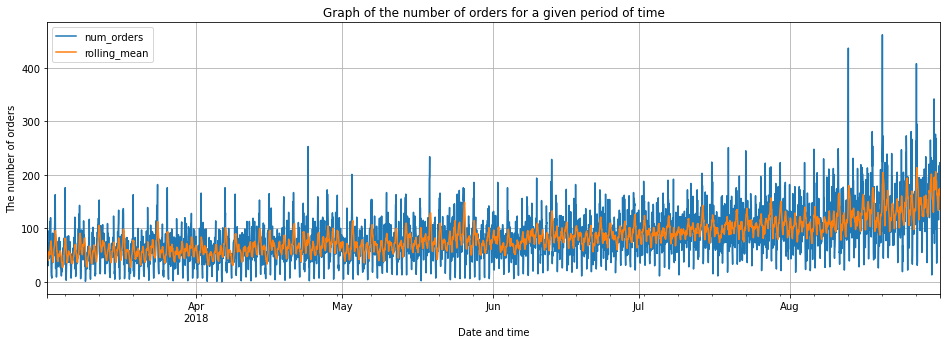

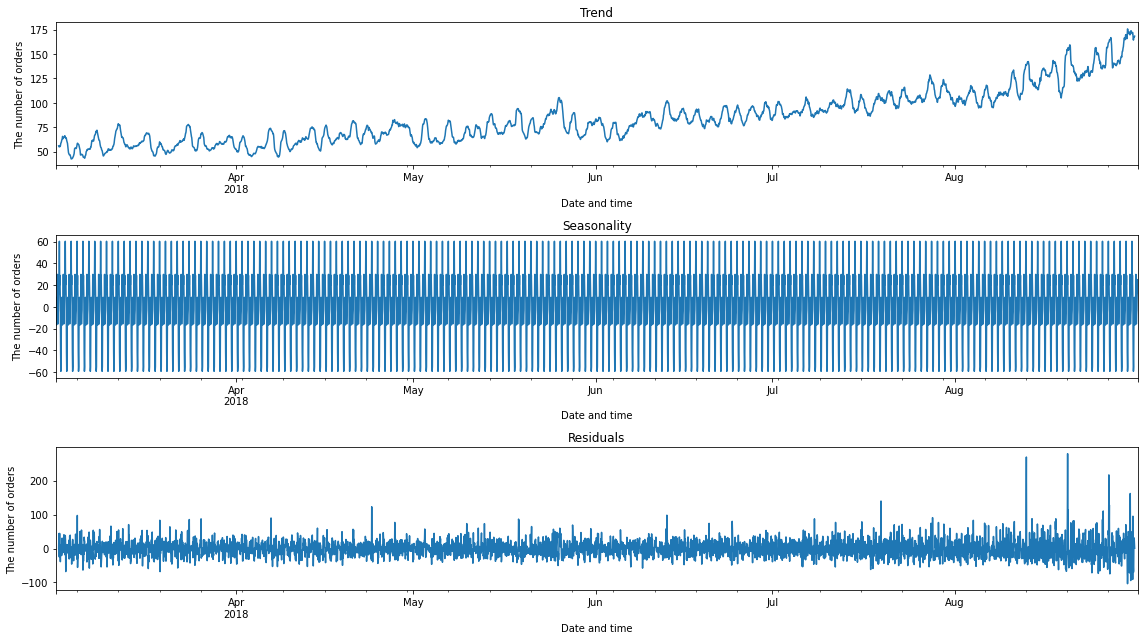

In [13]:
# Examine the period from March to August 2018.
time_series_describe(data_nona)

After analyzing the time series chart from March to August, we can draw the following conclusion.
There is a clear trend towards an increase in the average number of orders over time. Since mid-April, the average number of orders has been growing. Now consider shorter periods. For example April.

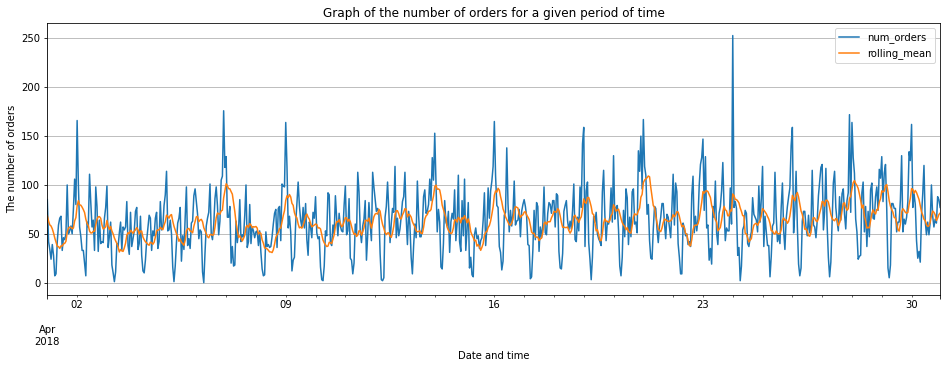

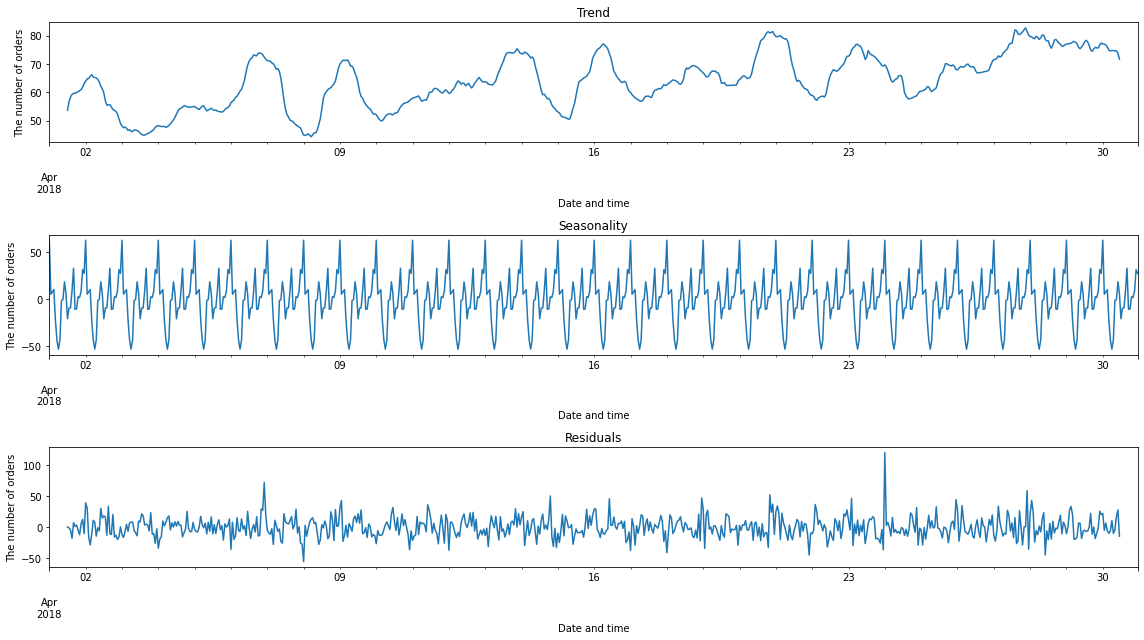

In [14]:
april = data_nona['2018-04-01':'2018-04-30']
time_series_describe(april)

After analyzing the time series charts for April 2018, we can conclude that the maximum values of the number of orders are reached in the period from Sunday to Monday and in the period between Friday and Saturday. At the same time, we also note a trend towards an overall increase in the number of orders during April. Consider the week of April from 9 to 16 April.

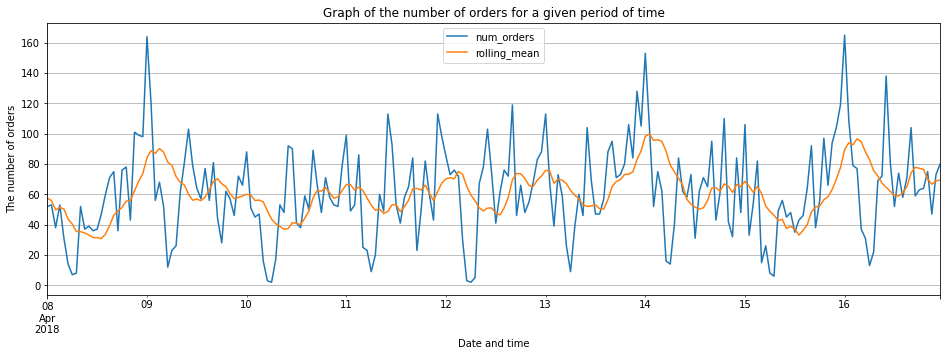

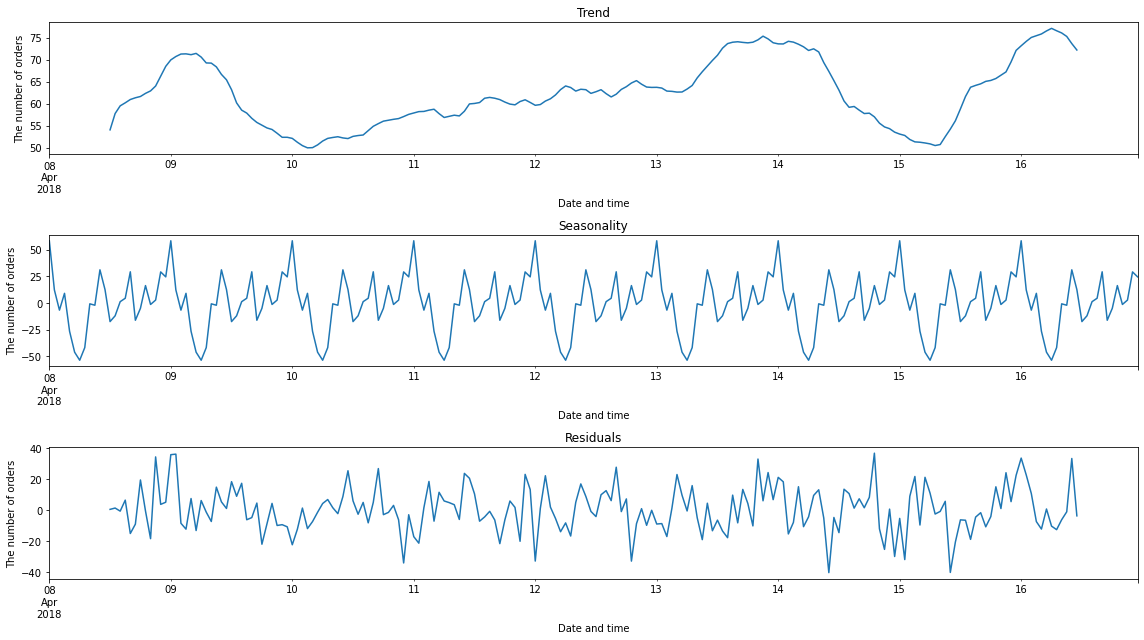

In [15]:
april = data_nona['2018-04-08':'2018-04-16']
time_series_describe(april)

After examinig the data for the week, we note that there is seasonality in the number of orders in terms of time of day. At night, the number of orders decreases. After 12 noon, the number of orders grows. Now consider the three days of any week in April: Wednesday, Friday, Sunday.

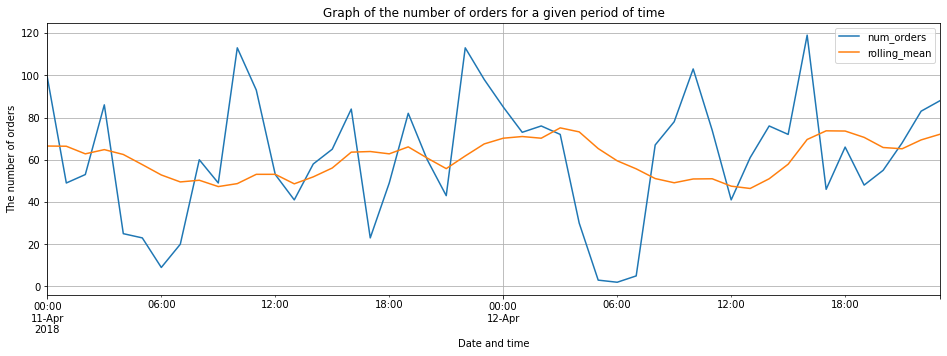

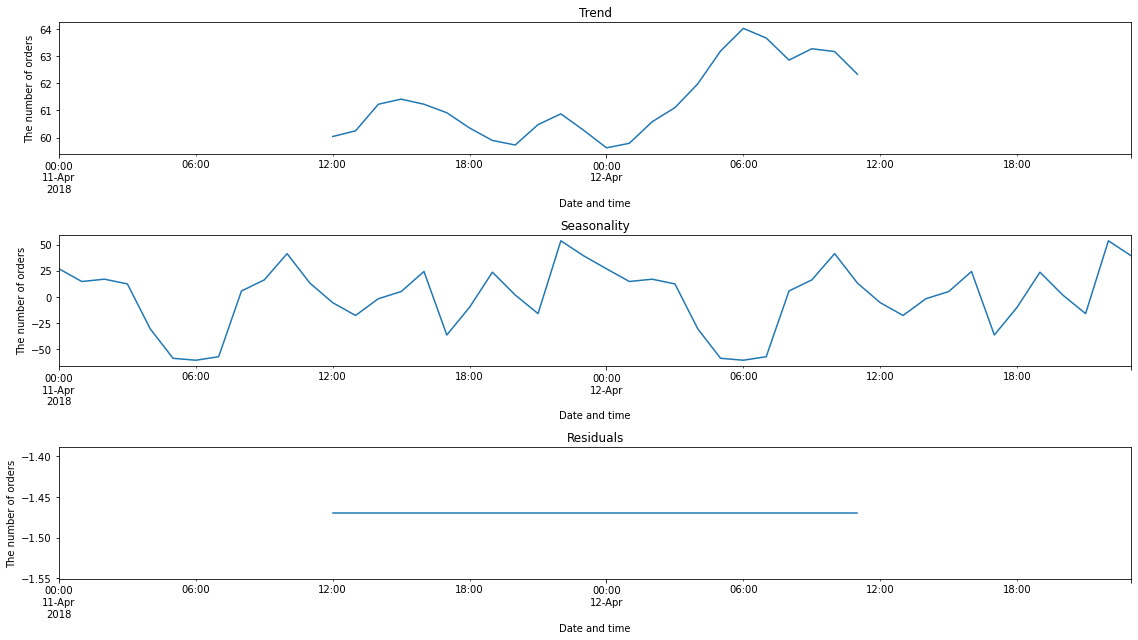

In [16]:
wednesday = data_nona['2018-04-11':'2018-04-12']
time_series_describe(wednesday)

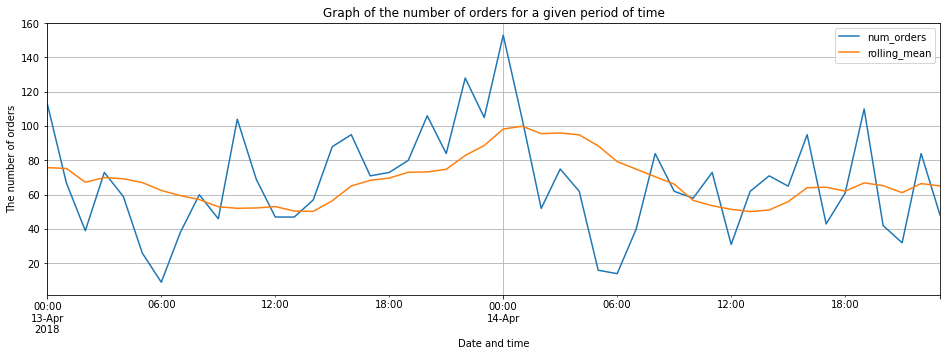

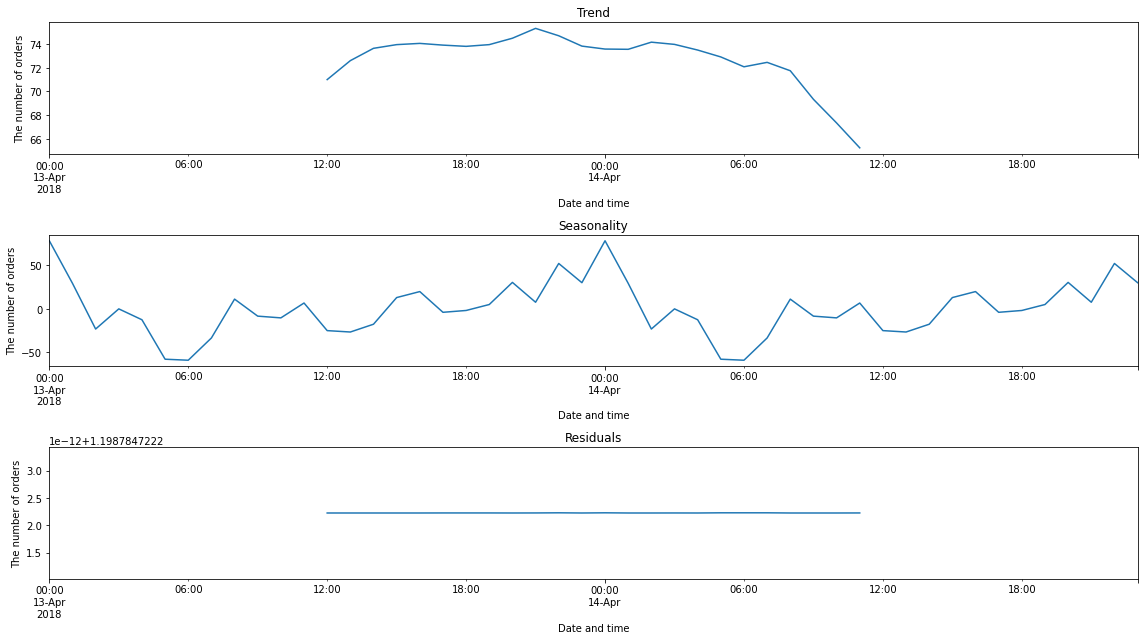

In [17]:
friday = data_nona['2018-04-13':'2018-04-14']
time_series_describe(friday)

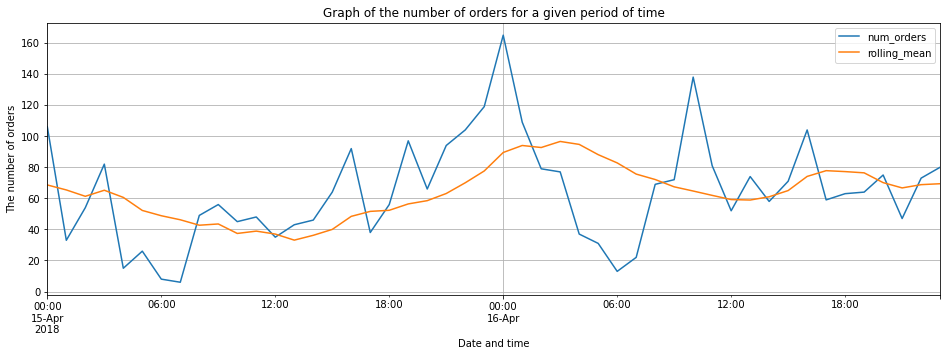

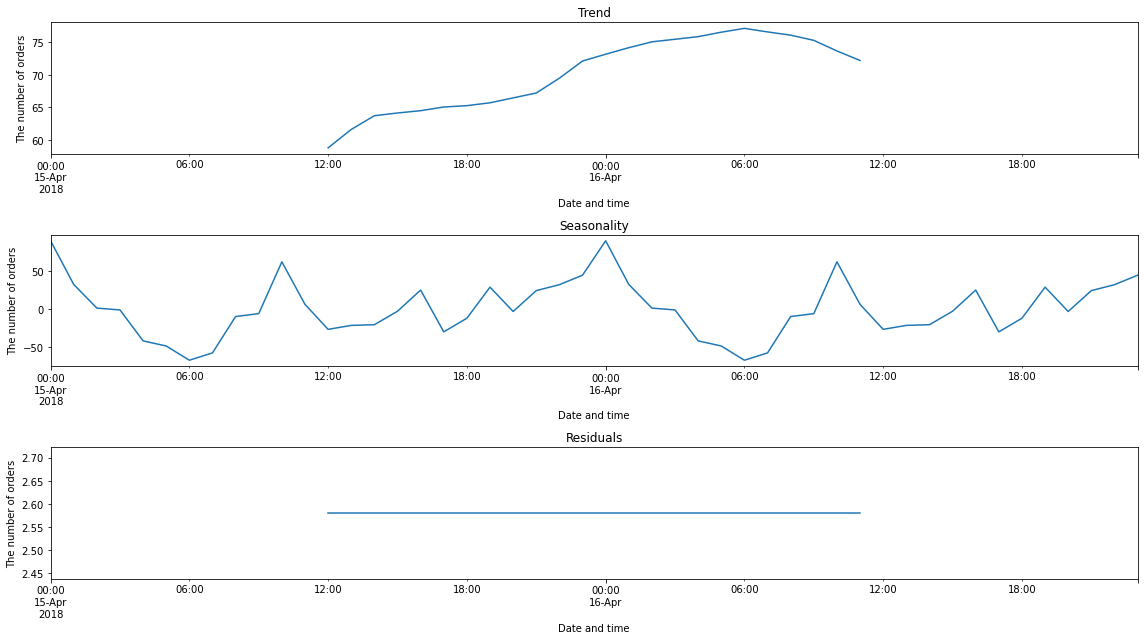

In [18]:
sunday = data_nona['2018-04-15':'2018-04-16']
time_series_describe(sunday)

An analysis of the three most significant days of the week revealed a seasonal pattern: approximately from 13-14 hours of the day, an increase in taxi requests begins. The increase ends at about 1-3 am. Then there is a decline to 13-14 hours.

### Conclusion

We analyzed the time series in several approximations. We estimated the period at 6 months, per month, per week, per day.
Our findings:
* There is a clear trend towards an increase in the average number of orders over time. Since mid-April, the average number of orders has been growing. At the same time, the nature of the change in the number of orders in all months is similar to each other. It can also be concluded that the time series is non-stationary. Over time, the average value of the number of orders changes, as indicated by the graph. However, the trend can be considered linear and, in general, the series is more stationary than it could be. Therefore, we will not find the difference in the values of this time series.
* Maximum order numbers are reached between Sunday and Monday and between Friday and Saturday.
* Detected seasonality in the number of orders in terms of time of day. At night, the number of orders decreases. After 12 noon, the number of orders grows. From about 13-14 hours of the day, an increase in requests for a taxi begins. The increase ends at about 1-3 am. Then there is a decline to 13-14 hours.
  
Data analysis completed. Let's move on to creating models and training them.

## Model training

In [19]:
# Create a function that make features.
def make_features(data, max_lag, rolling_mean_size):
    new_data = data.copy()
    new_data['month'] = new_data.index.month
    new_data['day'] = new_data.index.day
    new_data['dayofweek'] = new_data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        new_data['lag_{}'.format(lag)] = new_data[
            'num_orders'
        ].shift(lag)

    new_data['rolling_mean'] = new_data['num_orders'].shift(1).rolling(
        rolling_mean_size
    ).mean()
    return new_data

In [20]:
upd_data = make_features(data, 20, 4)
display(upd_data)

,num_orders,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,8,31,4,207.0,217.0,197.0,116.0,133.0,166.0,...,46.0,35.0,78.0,268.0,99.0,230.0,194.0,276.0,246.0,184.25
2018-08-31 20:00:00,154,8,31,4,136.0,207.0,217.0,197.0,116.0,133.0,...,182.0,46.0,35.0,78.0,268.0,99.0,230.0,194.0,276.0,189.25
2018-08-31 21:00:00,159,8,31,4,154.0,136.0,207.0,217.0,197.0,116.0,...,203.0,182.0,46.0,35.0,78.0,268.0,99.0,230.0,194.0,178.50


In [21]:
# Get rid of missing values.
# Prepare the target and other features
# for linear regression cross-validation.
upd_data = upd_data.dropna()

In [22]:
# Let's split the data into training and test sets.
train, test = train_test_split(
    upd_data,
    test_size=.1,
    shuffle=False
)
# Check sizes and chronological order.
print('Training set size is', train.shape)
print('Test size is', test.shape)
print('The time limits of the training set are', 
      train.index.min(), train.index.max())
print('The time limits of the test set are',
      test.index.min(), test.index.max())

Training set size is (3956, 25)
Test size is (440, 25)
The time limits of the training set are 2018-03-01 20:00:00 2018-08-13 15:00:00
The time limits of the test set are 2018-08-13 16:00:00 2018-08-31 23:00:00


In [23]:
# Define the target and other features of the training and test samples.
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']
# Check set sizes.
kits = [features_train, target_train, features_test, target_test]
kit_names = ['features_train', 'target_train', 'features_test', 'target_test']
for name, kit in zip(kit_names, kits):
    print('The size of the ' + name + ' set is', kit.shape)

The size of the features_train set is (3956, 24)
The size of the target_train set is (3956,)
The size of the features_test set is (440, 24)
The size of the target_test set is (440,)


In [24]:
# Let's make a RMSE scorer for cross-validation.
def rmse (answers, predictions):
    predictions = np.array(predictions)
    answers = np.array(answers)
    score = np.sqrt(((predictions - answers) ** 2).mean())
    return score
my_scorer = make_scorer(rmse, greater_is_better=False)

In [25]:
# Use a time-sensitive splitter.
# It will help us cross-validate correctly.
ts_cv = TimeSeriesSplit(
    n_splits=5,
    gap=48,
    max_train_size=2374,
    test_size=237
)

In [26]:
# Make sure the splitting is correct.
all_splits = list(ts_cv.split(features_train, target_train))
train_0, test_0 = all_splits[0]

In [27]:
# Consider the first split.
features_train.iloc[train_0]

,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-16 09:00:00,3,16,4,56.0,22.0,5.0,12.0,47.0,27.0,39.0,...,57.0,94.0,49.0,72.0,60.0,60.0,67.0,64.0,46.0,23.75
2018-03-16 10:00:00,3,16,4,44.0,56.0,22.0,5.0,12.0,47.0,27.0,...,85.0,57.0,94.0,49.0,72.0,60.0,60.0,67.0,64.0,31.75
2018-03-16 11:00:00,3,16,4,85.0,44.0,56.0,22.0,5.0,12.0,47.0,...,101.0,85.0,57.0,94.0,49.0,72.0,60.0,60.0,67.0,51.75
2018-03-16 12:00:00,3,16,4,61.0,85.0,44.0,56.0,22.0,5.0,12.0,...,110.0,101.0,85.0,57.0,94.0,49.0,72.0,60.0,60.0,61.50
2018-03-16 13:00:00,3,16,4,54.0,61.0,85.0,44.0,56.0,22.0,5.0,...,134.0,110.0,101.0,85.0,57.0,94.0,49.0,72.0,60.0,61.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-23 02:00:00,6,23,5,118.0,172.0,109.0,147.0,99.0,110.0,82.0,...,89.0,96.0,57.0,69.0,127.0,114.0,73.0,34.0,24.0,136.50
2018-06-23 03:00:00,6,23,5,155.0,118.0,172.0,109.0,147.0,99.0,110.0,...,75.0,89.0,96.0,57.0,69.0,127.0,114.0,73.0,34.0,138.50
2018-06-23 04:00:00,6,23,5,126.0,155.0,118.0,172.0,109.0,147.0,99.0,...,103.0,75.0,89.0,96.0,57.0,69.0,127.0,114.0,73.0,142.75


In [28]:
features_train.iloc[test_0]

,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-06-25 07:00:00,6,25,0,50.0,92.0,115.0,116.0,82.0,119.0,154.0,...,96.0,51.0,103.0,154.0,122.0,107.0,42.0,74.0,51.0,93.25
2018-06-25 08:00:00,6,25,0,36.0,50.0,92.0,115.0,116.0,82.0,119.0,...,84.0,96.0,51.0,103.0,154.0,122.0,107.0,42.0,74.0,73.25
2018-06-25 09:00:00,6,25,0,96.0,36.0,50.0,92.0,115.0,116.0,82.0,...,105.0,84.0,96.0,51.0,103.0,154.0,122.0,107.0,42.0,68.50
2018-06-25 10:00:00,6,25,0,101.0,96.0,36.0,50.0,92.0,115.0,116.0,...,124.0,105.0,84.0,96.0,51.0,103.0,154.0,122.0,107.0,70.75
2018-06-25 11:00:00,6,25,0,100.0,101.0,96.0,36.0,50.0,92.0,115.0,...,100.0,124.0,105.0,84.0,96.0,51.0,103.0,154.0,122.0,83.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-07-04 23:00:00,7,4,2,103.0,96.0,90.0,107.0,53.0,107.0,148.0,...,80.0,83.0,96.0,104.0,31.0,30.0,54.0,104.0,94.0,99.00
2018-07-05 00:00:00,7,5,3,110.0,103.0,96.0,90.0,107.0,53.0,107.0,...,85.0,80.0,83.0,96.0,104.0,31.0,30.0,54.0,104.0,99.75
2018-07-05 01:00:00,7,5,3,157.0,110.0,103.0,96.0,90.0,107.0,53.0,...,80.0,85.0,80.0,83.0,96.0,104.0,31.0,30.0,54.0,116.50


In [29]:
# Consider the last split.
train_4, test_4 = all_splits[4]
features_train.iloc[train_4]

,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-04-24 21:00:00,4,24,1,52.0,64.0,67.0,70.0,87.0,52.0,46.0,...,58.0,54.0,17.0,2.0,36.0,28.0,76.0,83.0,77.0,63.25
2018-04-24 22:00:00,4,24,1,99.0,52.0,64.0,67.0,70.0,87.0,52.0,...,74.0,58.0,54.0,17.0,2.0,36.0,28.0,76.0,83.0,70.50
2018-04-24 23:00:00,4,24,1,62.0,99.0,52.0,64.0,67.0,70.0,87.0,...,71.0,74.0,58.0,54.0,17.0,2.0,36.0,28.0,76.0,69.25
2018-04-25 00:00:00,4,25,2,86.0,62.0,99.0,52.0,64.0,67.0,70.0,...,40.0,71.0,74.0,58.0,54.0,17.0,2.0,36.0,28.0,74.75
2018-04-25 01:00:00,4,25,2,119.0,86.0,62.0,99.0,52.0,64.0,67.0,...,37.0,40.0,71.0,74.0,58.0,54.0,17.0,2.0,36.0,91.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-01 14:00:00,8,1,2,93.0,72.0,90.0,75.0,131.0,66.0,43.0,...,133.0,98.0,182.0,125.0,124.0,131.0,98.0,85.0,42.0,82.50
2018-08-01 15:00:00,8,1,2,88.0,93.0,72.0,90.0,75.0,131.0,66.0,...,95.0,133.0,98.0,182.0,125.0,124.0,131.0,98.0,85.0,85.75
2018-08-01 16:00:00,8,1,2,113.0,88.0,93.0,72.0,90.0,75.0,131.0,...,122.0,95.0,133.0,98.0,182.0,125.0,124.0,131.0,98.0,91.50


In [30]:
features_train.iloc[test_4]

,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-08-03 19:00:00,8,3,4,91.0,142.0,140.0,96.0,75.0,106.0,96.0,...,54.0,86.0,51.0,172.0,78.0,125.0,130.0,178.0,170.0,117.25
2018-08-03 20:00:00,8,3,4,91.0,91.0,142.0,140.0,96.0,75.0,106.0,...,87.0,54.0,86.0,51.0,172.0,78.0,125.0,130.0,178.0,116.00
2018-08-03 21:00:00,8,3,4,87.0,91.0,91.0,142.0,140.0,96.0,75.0,...,114.0,87.0,54.0,86.0,51.0,172.0,78.0,125.0,130.0,102.75
2018-08-03 22:00:00,8,3,4,123.0,87.0,91.0,91.0,142.0,140.0,96.0,...,159.0,114.0,87.0,54.0,86.0,51.0,172.0,78.0,125.0,98.00
2018-08-03 23:00:00,8,3,4,170.0,123.0,87.0,91.0,91.0,142.0,140.0,...,105.0,159.0,114.0,87.0,54.0,86.0,51.0,172.0,78.0,117.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-13 11:00:00,8,13,0,156.0,137.0,91.0,39.0,66.0,83.0,143.0,...,185.0,118.0,135.0,98.0,82.0,78.0,115.0,153.0,149.0,105.75
2018-08-13 12:00:00,8,13,0,144.0,156.0,137.0,91.0,39.0,66.0,83.0,...,160.0,185.0,118.0,135.0,98.0,82.0,78.0,115.0,153.0,132.00
2018-08-13 13:00:00,8,13,0,92.0,144.0,156.0,137.0,91.0,39.0,66.0,...,273.0,160.0,185.0,118.0,135.0,98.0,82.0,78.0,115.0,132.25


The splitting process was carried out correctly.

### Linear Regression

In [31]:
# Create a linear regression model.
model_lr = LinearRegression()
# Do a cross-validation.
cv_results = cross_validate(
        model_lr,
        features_train,
        target_train,
        cv=ts_cv,
        scoring=my_scorer)
final_score = abs(cv_results['test_score'].mean())
print('Best RMSE is', final_score)
lr_score = final_score

Best RMSE is 34.01521232052839


### Decision Tree

In [32]:
# Create a decision tree model.
model_dt = DecisionTreeRegressor(random_state=12345)
parameters_set = {
    'max_depth': [2, 4, 7, 10],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 6]
}
# Adjsut the hyperparameters.
grid_cv_dt = GridSearchCV(estimator=model_dt,
                      param_grid=parameters_set,
                      scoring=my_scorer,
                      cv=ts_cv,
                      n_jobs=-1)
grid_cv_dt.fit(features_train, target_train)
# Best pareameters are:
best_parameters = grid_cv_dt.best_params_
print('Best parameters are:\n', best_parameters)
# Best RMSE is:
best_cv_dt_score = abs(grid_cv_dt.best_score_)
print('Best RMSE is', best_cv_dt_score)

Best parameters are:
 {'max_depth': 7, 'min_samples_leaf': 6, 'min_samples_split': 2}
Best RMSE is 36.95596376016775


### Random forest

In [33]:
# Create a random forest model.
model_rf = RandomForestRegressor(random_state=12345)
parameters_set = {
    'max_depth': [2, 5, 8, 11],
    'n_estimators': [20, 40, 60, 80],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 6]
}
# Adjust the hyperparameters.
grid_cv_rf = GridSearchCV(estimator=model_rf,
                      param_grid=parameters_set,
                      scoring=my_scorer,
                      cv=ts_cv,
                      n_jobs=-1)
grid_cv_rf.fit(features_train, target_train)
# Best parameters are:
best_parameters = grid_cv_rf.best_params_
print('Best parameters are:\n', best_parameters)
# Best RMSE is:
best_cv_rf_score = abs(grid_cv_rf.best_score_)
print('Best RMSE is', best_cv_rf_score)

Best parameters are:
 {'max_depth': 11, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 80}
Best RMSE is 32.06779891180256


### Gradient boosting

In [34]:
# Create a gradient boosting model
# using Light GBM.
model_gb = lgb.LGBMRegressor(boosting_type='gbdt', random_state=12345)
param_grid = {
    'num_leaves': [15, 30, 40, 50], 
    'max_depth': [5, 10, 15, 30],
    'n_estimators' : [30, 60, 80, 100],
    'min_child_samples': [10, 30, 50, 70]
}
# Adjust the hyperparameters.
grid_cv_gb = GridSearchCV(estimator=model_gb, 
                          param_grid=param_grid, 
                          scoring=my_scorer,
                          cv=ts_cv,
                          n_jobs=-1)
grid_cv_gb.fit(features_train, target_train)
# Best parameters are:
best_parameters = grid_cv_gb.best_params_
print('Best parameters are:\n', best_parameters)
# Best RMSE is:
best_cv_gb_score = abs(grid_cv_gb.best_score_)
print('Best RMSE is', best_cv_gb_score)

Best parameters are:
 {'max_depth': 10, 'min_child_samples': 10, 'n_estimators': 80, 'num_leaves': 30}
Best RMSE is 31.23615445269985


### Conclusion

We prepared a function that takes a dataset with a time series as input, and modifies it at the output by adding features such as month, day of the week, day, lagging values, moving average.
We also created four different models: linear regression, decision tree, random forest and gradient boosting.
Using the cross-validation method, we selected the best parameters for each model and identified the best value of the RMSE metric.
We will test the gradient boosting model.

In [35]:
# Let's create a table with the results.
rmse_results = pd.DataFrame(
    {'RMSE after the cross-validation':[lr_score, 
             best_cv_dt_score, best_cv_rf_score, best_cv_gb_score]}, 
    index=[
        'Linear Regression',  
        'Decision Tree', 
        'Random Forest',
        'Gradient Boosting'
    ]
)
rmse_results.index.name = 'Model'
display(rmse_results)

,RMSE after the cross-validation
Model,
Linear Regression,34.015212
Decision Tree,36.955964
Random Forest,32.067799
Gradient Boosting,31.236154


## Testing the model

In [36]:
# Create a gradient boosting model
# using the Light GBM library.
# Let's change the hyperparameters a bit.
model = lgb.LGBMRegressor(boosting_type='gbdt',
                             max_depth=30,
                             min_child_samples=10,
                             n_estimators=100,
                             num_leaves=30,
                             random_state=12345)
# Train the model.
model.fit(features_train, target_train)
# Make predictions.
predictions = pd.Series(
    model.predict(features_test), 
    index=target_test.index
    )
# Calculate RMSE
rmse = (mean_squared_error(target_test, predictions))**0.5
print('RMSE is', rmse)
if rmse > 48:
    print('The required value of the RMSE metric has not been reached. Improvement is required.')
elif 0 <= rmse <= 48:
    print('The required value of the RMSE metric has been reached.')
else:
    print('RMSE is negative. Improvement is required.')

RMSE is 45.92666227202384
The required value of the RMSE metric has been reached.


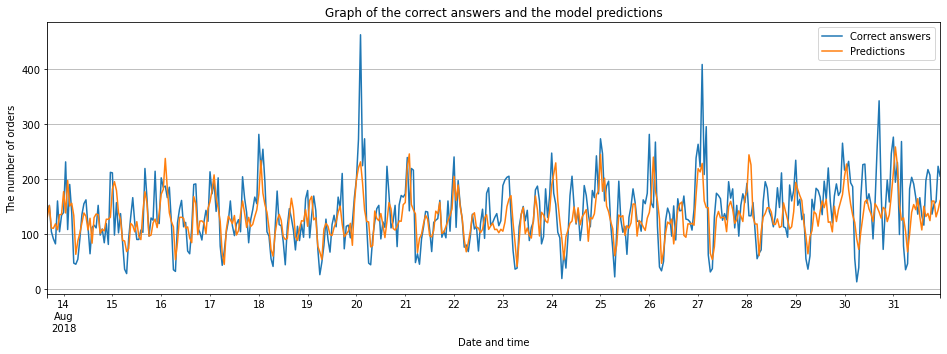

In [37]:
# Visualize the predictions and the correct answers.
final_result = pd.concat([target_test, predictions], axis=1)
final_result.columns = ['Correct answers', 'Predictions']
final_result.plot(
        kind='line',
        figsize=(16,5),
        grid=True
    )
plt.xlabel('Date and time')
plt.ylabel('The number of orders')
plt.title('Graph of the correct answers and the model predictions')
plt.show()

Let's do some sanity check.

In [38]:
# Check our model with the previous values.
# Move values forward.
predictions_previous = target_test.shift()
# Replace the resulting NaN-value
# to the last one from the training set.
predictions_previous.iloc[0] = target_train.iloc[-1]
dummy_rmse = (mean_squared_error(target_test, predictions_previous))**0.5
print('Dummy model RMSE is', dummy_rmse)
if dummy_rmse > rmse:
    print('Our model is sane')
else:
    print('Our model is insane. Improvement is required.')

Dummy model RMSE is 58.881776776551476
Our model is sane


In [39]:
# Let's take a look at feature_importances attribute.
# Let's create a function.
def importance(model, features):
    importance = model.feature_importances_
    colums_features = features.columns 
    importance = pd.Series(importance, index=colums_features)
    importance.sort_values(ascending=False).plot(
        kind='bar', x=importance.index, y=importance,
        title='Feature importances bar chart'
    )

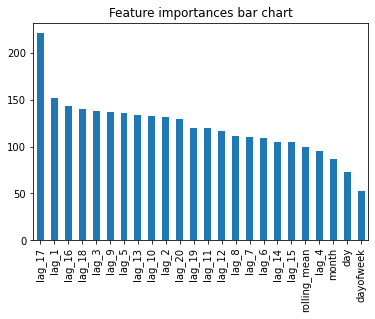

In [40]:
importance(model, features_train)

### Conclusion

The selected gradient boosting model passed the test. The RMSE metric was 45.92, which means the customer's condition is met.
The model is sanity tested with a dummy model based on previous values. Our model is sane.
At the end of the study, we assessed the degree of influence of features on the target feature. It is curious that among the feature of the "date-time" format, only month turned out to be quite significant. The most significant were features containing lagging values.

## General conclusion

* We downloaded and examined the data on the number of taxi orders provided by the taxi service. The time series was resampled for one hour.
* Carried out the analysis of the time series with subsequent decomposition. Trends and seasonality were determined in four time approximations (6 months, month, week, day).
* We created the features needed to create our model. The dataset was splitted into training and test sets. Then we considered four models, tuning their hyperparameters in order to obtain the smallest value of the RMSE metric. The best value was shown by the gradient boosting model.
* Tested the gradient boosting model. The model is sane and provides a given level of quality by the customer.